In [1]:
from google.colab import drive

In [2]:
import os
os.getcwd()

'/content'

In [3]:
drive.mount('content')

Mounted at content


In [4]:
import os
os.chdir('/content/content/MyDrive/HAR')

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout,SimpleRNN
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
dataTest = pd.read_csv('og data/dataTest.csv')
dataTrain = pd.read_csv('og data/dataTrain.csv')
yTrain = pd.read_csv('yTrain.csv')
yTest = pd.read_csv('yTest.csv')

yTrain  = yTrain.iloc[:,1]
yTest = yTest.iloc[:,1]


In [7]:


from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.utils import to_categorical

# Number of classes
num_classes = yTrain.value_counts().shape[0]

# Convert labels to one-hot encoding
onehot = lambda Y: to_categorical(Y - 1, num_classes=num_classes)
yTrain_onehot = onehot(yTrain)
yTest_onehot = onehot(yTest)

# Build RNN Model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, input_shape=(dataTrain.shape[1], 1)))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dense(num_classes, activation='softmax'))

# Add Gradient Clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile Model with Clipping
model_rnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history_rnn = model_rnn.fit(dataTrain, yTrain_onehot, epochs=100, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.4712 - loss: 1.2431
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.6916 - loss: 0.6895
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7467 - loss: 0.5708
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.7694 - loss: 0.5432
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.7742 - loss: 0.5311
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.7922 - loss: 0.5024
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.8031 - loss: 0.4737
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8044 - loss: 0.4664
Epoch 9/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.8103 - loss: 0.4522
Epoch 10/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.8123 - loss: 0.4586
Epoch 11/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.8071 - loss: 0.4546
Epoch 12/10

In [8]:
y_pred = model_rnn.predict(dataTest)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, confusion_matrix, classification_report,
                             average_precision_score, recall_score, precision_score,
                             f1_score, accuracy_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize


roc_auc_scores = []
accuracies = []
def evaluate_model(y_test, y_pred, history):

    y_test = y_test-1
    y_pred = np.array(y_pred)

    y_test_one_hot = label_binarize(y_test, classes=np.arange(num_classes))
    # Convert y_pred from probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
    roc_auc_scores.append(roc_auc)
    print(f'\nROC-AUC Score: {roc_auc:.4f}')

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred_labels)
    accuracies.append(accuracy)

    print(f'Accuracy Score: {accuracy:.4f}')

    # Plotting Iterations vs Cost
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Iterations vs Cost')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    print('Confusion Matrix:')
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report (Precision, Recall, F1 Score)
    class_report = classification_report(y_test, y_pred_labels, target_names=labels)
    print('Classification Report:')
    print(class_report)

    # Mean Average Precision and Recall
    avg_precision = average_precision_score(y_test_one_hot, y_pred, average='macro')
    avg_recall = recall_score(y_test, y_pred_labels, average='macro')
    print(f'Mean Average Precision: {avg_precision:.4f}')
    print(f'Mean Average Recall: {avg_recall:.4f}')

    # Class-wise Precision, Recall, and F1 Score
    precision = precision_score(y_test, y_pred_labels, average=None)
    recall = recall_score(y_test, y_pred_labels, average=None)
    f1 = f1_score(y_test, y_pred_labels, average=None)

    print('\nClass-wise Precision, Recall, and F1 Score:')
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f'Class {i+1} ({labels[i]}): Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}')


    plt.figure(figsize=(8,12))
    n_classes = y_test_one_hot.shape[1]
    all_fpr = np.array([])
    all_tpr = np.array([])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1}')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0, 0.4])
    plt.ylim([0.4, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()






ROC-AUC Score: 0.9880
Accuracy Score: 0.8844


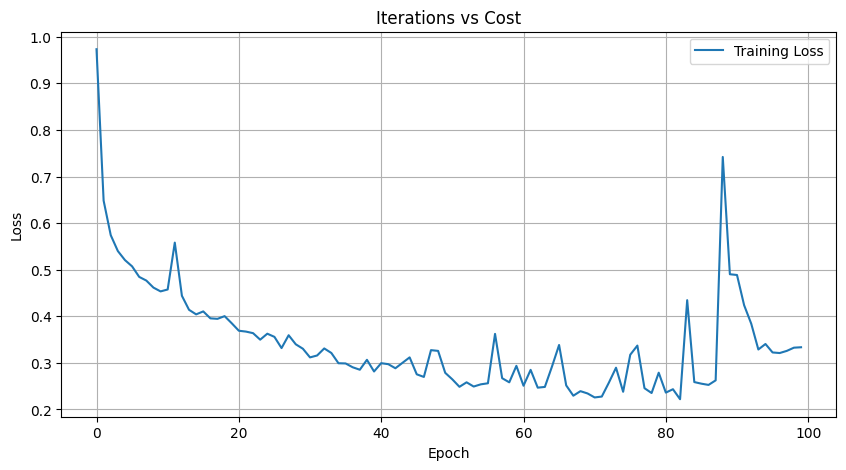

Confusion Matrix:


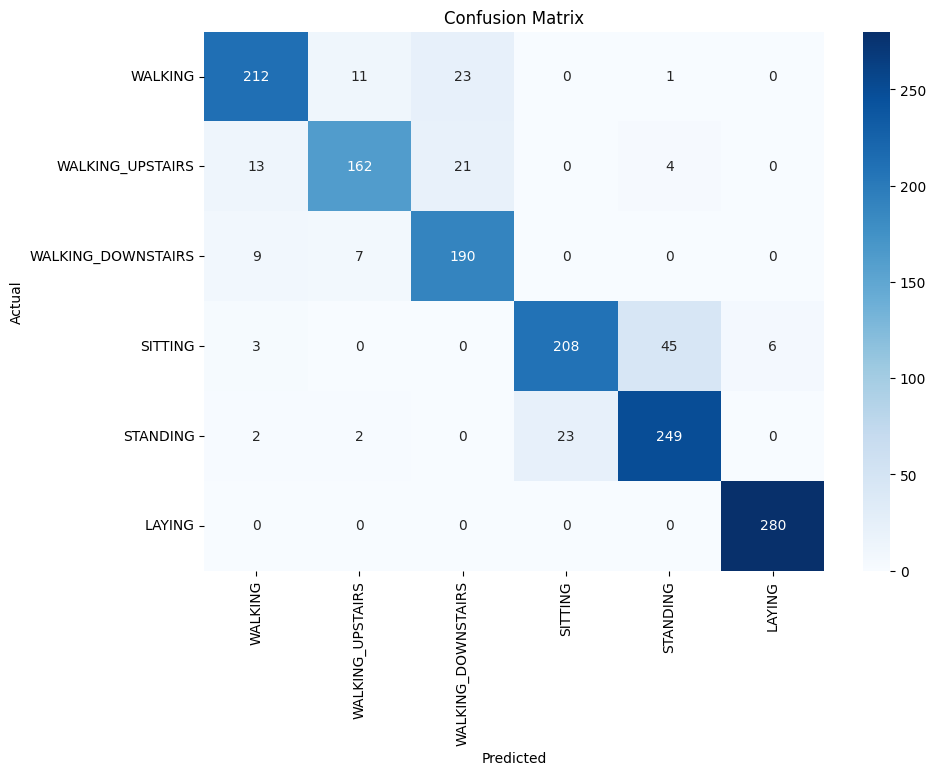

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.89      0.86      0.87       247
  WALKING_UPSTAIRS       0.89      0.81      0.85       200
WALKING_DOWNSTAIRS       0.81      0.92      0.86       206
           SITTING       0.90      0.79      0.84       262
          STANDING       0.83      0.90      0.87       276
            LAYING       0.98      1.00      0.99       280

          accuracy                           0.88      1471
         macro avg       0.88      0.88      0.88      1471
      weighted avg       0.89      0.88      0.88      1471

Mean Average Precision: 0.9473
Mean Average Recall: 0.8811

Class-wise Precision, Recall, and F1 Score:
Class 1 (WALKING): Precision: 0.8870, Recall: 0.8583, F1 Score: 0.8724
Class 2 (WALKING_UPSTAIRS): Precision: 0.8901, Recall: 0.8100, F1 Score: 0.8482
Class 3 (WALKING_DOWNSTAIRS): Precision: 0.8120, Recall: 0.9223, F1 Score: 0.8636
Class 4 (SITTING): Precision: 0.9004,

<Figure size 800x1200 with 0 Axes>

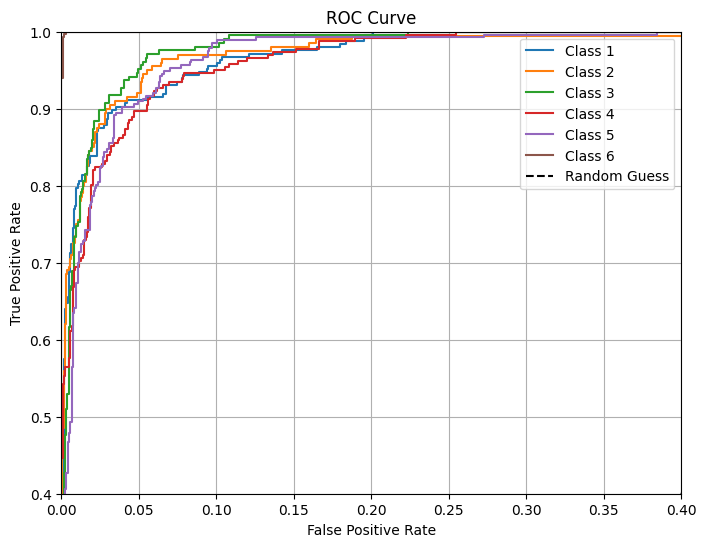

In [10]:
evaluate_model(yTest, y_pred, history_rnn)

In [11]:
dataTest_pca = pd.read_csv('pca datasets/dataTest_pca.csv')
dataTrain_pca = pd.read_csv('pca datasets/dataTrain_pca.csv')

In [12]:
history_pca = model_rnn.fit(dataTrain_pca, yTrain_onehot, epochs=100, batch_size=32)
y_pred_pca = model_rnn.predict(dataTest_pca)


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1880 - loss: 2.9984
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.2360 - loss: 1.7646
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2389 - loss: 1.7365
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2771 - loss: 1.6733
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2650 - loss: 1.6844
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2773 - loss: 1.6649
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2765 - loss: 1.6438
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3088 - loss: 1.6197
Epoch 9/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.2948 - loss: 1.6088
Epoch 10/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3010 - loss: 1.6261
Epoch 11/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2966 - loss: 1.6434
Epoch 12/100
184/184 ━━━━━━━


ROC-AUC Score: 0.7699
Accuracy Score: 0.3725


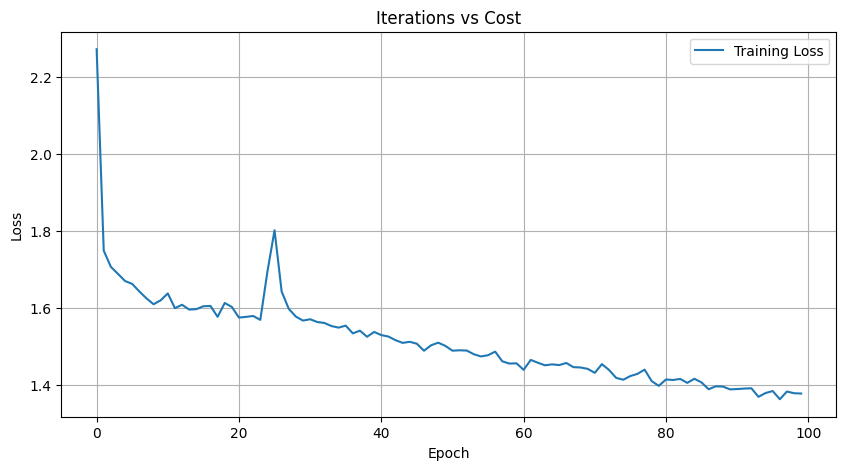

Confusion Matrix:


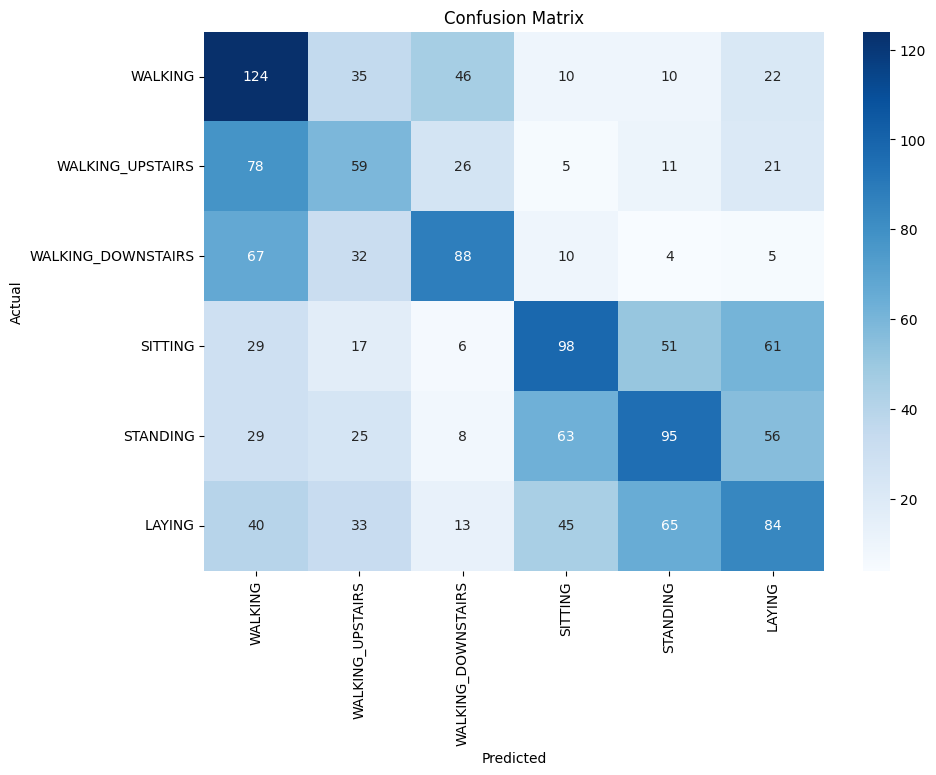

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.34      0.50      0.40       247
  WALKING_UPSTAIRS       0.29      0.29      0.29       200
WALKING_DOWNSTAIRS       0.47      0.43      0.45       206
           SITTING       0.42      0.37      0.40       262
          STANDING       0.40      0.34      0.37       276
            LAYING       0.34      0.30      0.32       280

          accuracy                           0.37      1471
         macro avg       0.38      0.37      0.37      1471
      weighted avg       0.38      0.37      0.37      1471

Mean Average Precision: 0.3963
Mean Average Recall: 0.3737

Class-wise Precision, Recall, and F1 Score:
Class 1 (WALKING): Precision: 0.3379, Recall: 0.5020, F1 Score: 0.4039
Class 2 (WALKING_UPSTAIRS): Precision: 0.2935, Recall: 0.2950, F1 Score: 0.2943
Class 3 (WALKING_DOWNSTAIRS): Precision: 0.4706, Recall: 0.4272, F1 Score: 0.4478
Class 4 (SITTING): Precision: 0.4242,

<Figure size 800x1200 with 0 Axes>

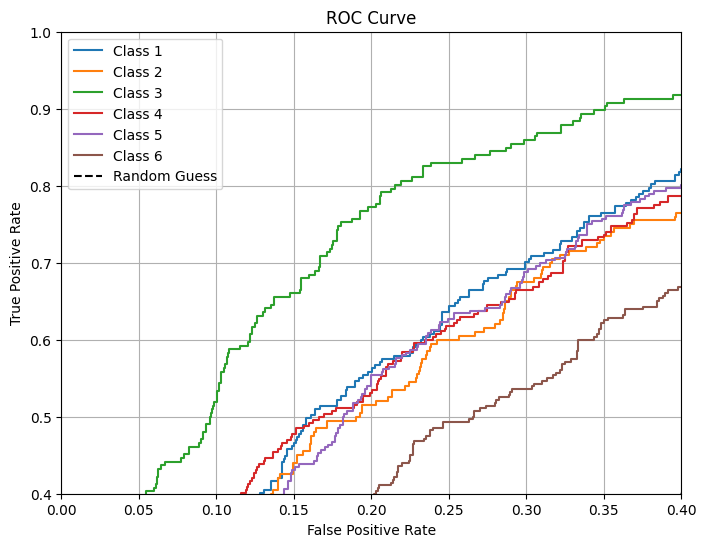

In [13]:
evaluate_model(yTest, y_pred_pca, history_pca)

In [18]:
dataTest_rfecv = pd.read_csv('rfecv stuff/dataTest_rfecv.csv')
dataTrain_rfecv = pd.read_csv('rfecv stuff/dataTrain_rfecv.csv')

In [ ]:
history_rfecv = model_rnn.fit(dataTrain_rfecv, yTrain_onehot, epochs=100, batch_size=32)
y_pred_rfecv = model_rnn.predict(dataTest_rfecv)


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.4342 - loss: 1.5769
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7267 - loss: 0.6769
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.7600 - loss: 0.5598
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.7860 - loss: 0.5163
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.7867 - loss: 0.5089
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7913 - loss: 0.5032
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.8043 - loss: 0.4846
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8095 - loss: 0.4631
Epoch 9/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8149 - loss: 0.4539
Epoch 10/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.8236 - loss: 0.4295
Epoch 11/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.8190 - loss: 0.4405
Epoch 12/100
184/1


ROC-AUC Score: 0.9776
Accuracy Score: 0.8307


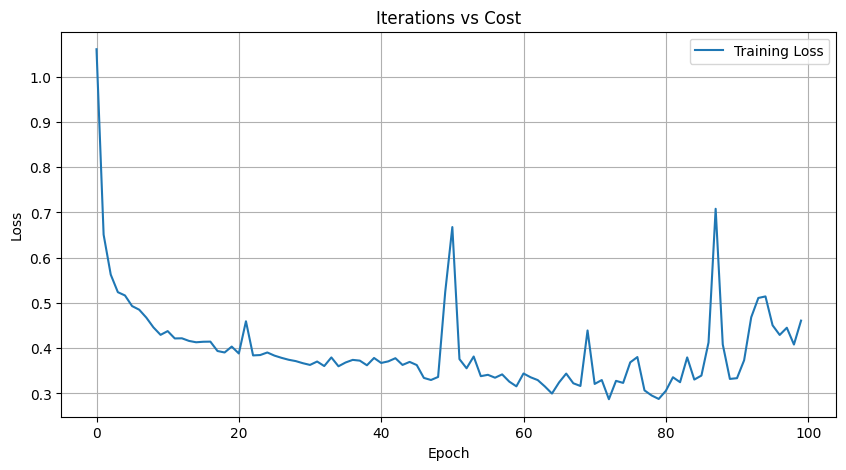

Confusion Matrix:


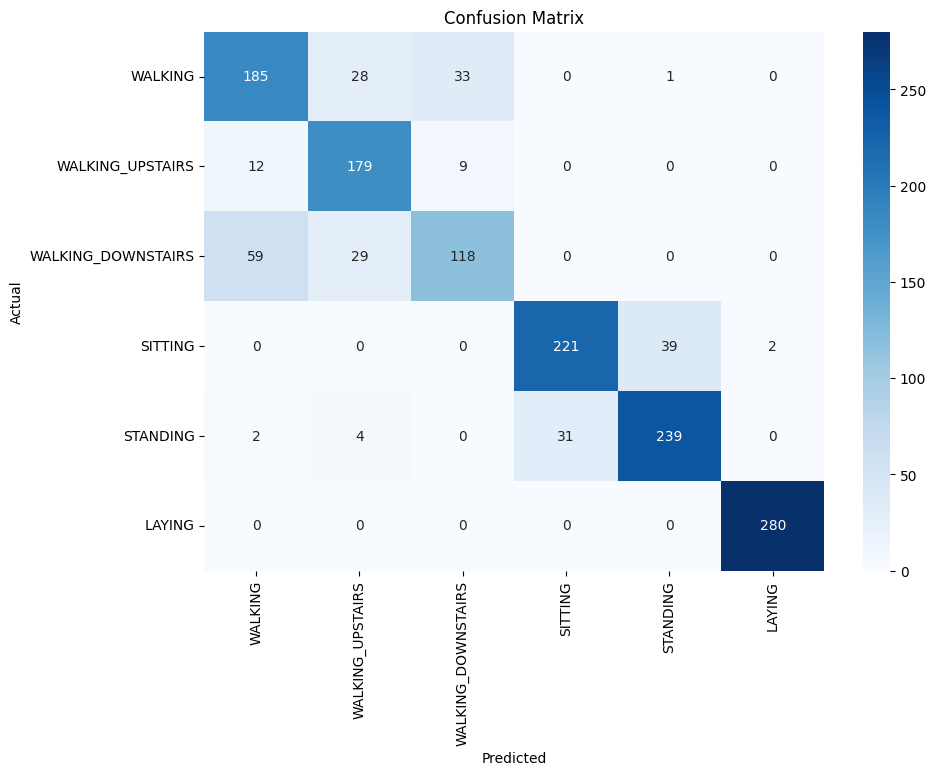

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.72      0.75      0.73       247
  WALKING_UPSTAIRS       0.75      0.90      0.81       200
WALKING_DOWNSTAIRS       0.74      0.57      0.64       206
           SITTING       0.88      0.84      0.86       262
          STANDING       0.86      0.87      0.86       276
            LAYING       0.99      1.00      1.00       280

          accuracy                           0.83      1471
         macro avg       0.82      0.82      0.82      1471
      weighted avg       0.83      0.83      0.83      1471

Mean Average Precision: 0.8926
Mean Average Recall: 0.8210

Class-wise Precision, Recall, and F1 Score:
Class 1 (WALKING): Precision: 0.7171, Recall: 0.7490, F1 Score: 0.7327
Class 2 (WALKING_UPSTAIRS): Precision: 0.7458, Recall: 0.8950, F1 Score: 0.8136
Class 3 (WALKING_DOWNSTAIRS): Precision: 0.7375, Recall: 0.5728, F1 Score: 0.6448
Class 4 (SITTING): Precision: 0.8770,

<Figure size 800x1200 with 0 Axes>

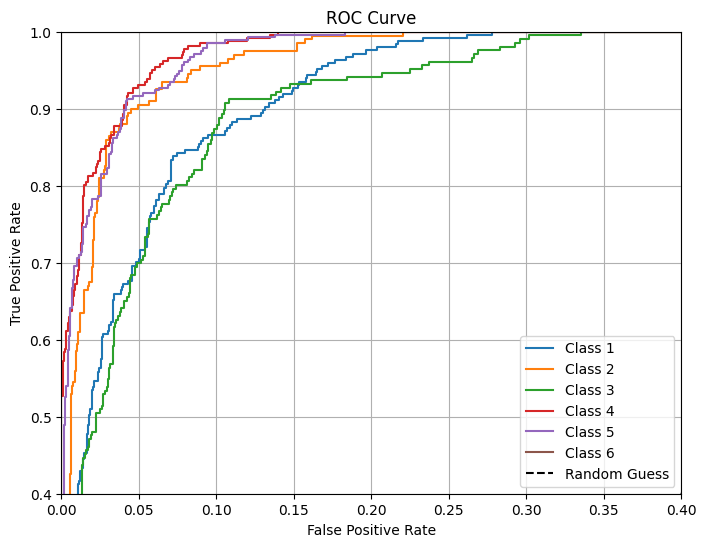

In [19]:
evaluate_model(yTest, y_pred_rfecv, history_rfecv)